In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import lammps_postp as lp

/home/vpalacio/anaconda3/envs/md-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
work_dir = Path('/home/vpalacio/scruggs/lc-2pt/quenched_tsweep')


In [3]:
mydir = work_dir / 'T_0.2'
style = 'id resid type x y z vx vy vz'
u = mda.Universe(mydir / 'system.data',
                 mydir / 'traj/trajectory.lammpstrj', atom_style=style,
                 topology_format="data", format="lammpsdump")

print(u)



<Universe with 36000 atoms>


/home/vpalacio/anaconda3/envs/md-env/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


In [4]:
# Example usage
molecules = lp.analysis.get_molecules(u)
print(f"Number of molecules: {len(molecules)}")

Number of molecules: 4500


In [5]:
print("Number of atoms:", len(u.atoms))
print("Number of residues:", len(u.residues))
print("Atoms per residue:", [len(res.atoms) for res in u.residues][:5])  # First 5
print("\nAtom attributes:")
print(u.atoms[0:10])  # First 10 atoms


Number of atoms: 36000
Number of residues: 4500
Atoms per residue: [8, 8, 8, 8, 8]

Atom attributes:
<AtomGroup [<Atom 1: of type 1 resid 1 and segid SYSTEM>, <Atom 2: of type 3 resid 1 and segid SYSTEM>, <Atom 3: of type 3 resid 1 and segid SYSTEM>, <Atom 4: of type 3 resid 1 and segid SYSTEM>, <Atom 5: of type 3 resid 1 and segid SYSTEM>, <Atom 6: of type 3 resid 1 and segid SYSTEM>, <Atom 7: of type 3 resid 1 and segid SYSTEM>, <Atom 8: of type 2 resid 1 and segid SYSTEM>, <Atom 9: of type 1 resid 2 and segid SYSTEM>, <Atom 10: of type 3 resid 2 and segid SYSTEM>]>


In [6]:

# Calculate properties for first frame
orientations = []
for mol_id, atoms in molecules.items():
    orient = lp.analysis.calc_orientation(atoms)
    orientations.append(orient)

In [7]:
S = lp.analysis.calc_order_parameter(orientations)
print(f"Order parameter S: {S:.3f}")

Order parameter S: 0.979


In [8]:

# Select frame (e.g., first frame)
ts = u.trajectory[0]
box = ts.dimensions[:3]
positions = u.atoms.positions

# Calculate hexatic order
mol_positions = lp.analysis.get_molecular_com(u,molecules)
psi6, psi6_local = lp.analysis.calc_hexatic_order(mol_positions, box)

print(f"Global hexatic order: {psi6:.3f}")
print(f"Local order statistics:")
print(f"Mean: {np.mean(np.abs(psi6_local)):.3f}")
print(f"Std: {np.std(np.abs(psi6_local)):.3f}")

Global hexatic order: 0.000
Local order statistics:
Mean: 0.000
Std: 0.021


Frame 0/365
Frame 100/365
Frame 200/365
Frame 300/365


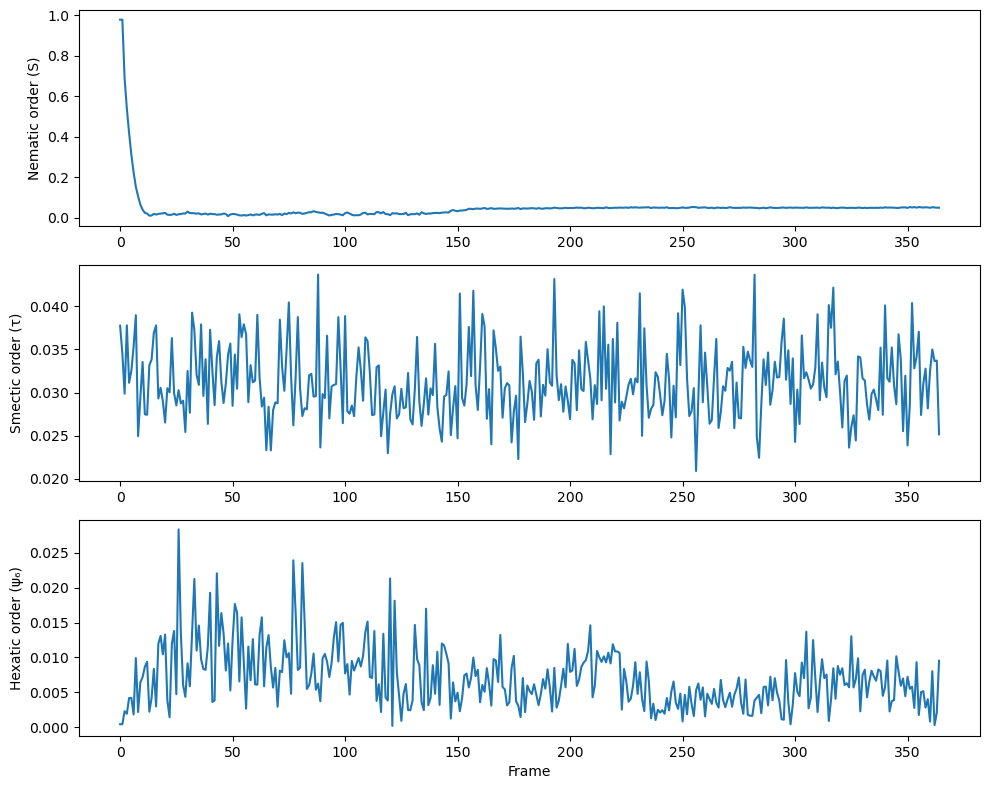

In [10]:

# Initialize data lists
data = []
molecules = lp.analysis.get_molecules(u)


# Analyze each frame
results = {
    'S': [],
    'tau': [],
    'chi': [],
    'psi6': []
}

for ts in u.trajectory:
    frame_results = lp.analysis.analyze_frame(u, molecules)

    for key in results:
        results[key].append(frame_results[key])

            # Progress update
    if ts.frame % 100 == 0:
        print(f"Frame {ts.frame}/{len(u.trajectory)}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

ax1.plot(results['S'])
ax1.set_ylabel('Nematic order (S)')

ax2.plot(results['tau'])
ax2.set_ylabel('Smectic order (τ)')

ax3.plot(results['psi6'])
ax3.set_ylabel('Hexatic order (ψ₆)')

ax3.set_xlabel('Frame')
plt.tight_layout()
plt.show()


